# Detecting (highly) similar questions

In [ ]:
%load_ext tensorboard

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:  # see name of allocated GPU
  print(gpu_info)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Tue Oct 18 13:26:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------

In [ ]:
SEED = 46

In [ ]:
!pip install joblib==1.1.0
!pip install -U sentence-transformers
!pip install scikit-learn
!pip install hyperopt
!pip install umap-learn
!pip install hdbscan
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Text Embeddings
As the goal is to filter sentences with similar meaning, we use sentence-level embeddings, rather than word-level representations. IN particular, here we leverage Sentence-BERT [Reimers and Gurevych, 2020], a “modification of the pretrained BERT network that use siamese and triplet network structures to derive semantically meaningful sentence embeddings that can be compared using cosine-similarity”.



In [ ]:
!wget -O questions.txt https://raw.githubusercontent.com/FiorelaCiroku/Ontology-Reverse-Engineering/main/Data/CQList/ComicsCharacter.txt

!wget -O qqp.tsv http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv

with open('questions.txt') as f:
    questions = f.readlines()

--2022-10-18 13:27:35--  https://raw.githubusercontent.com/FiorelaCiroku/Ontology-Reverse-Engineering/main/Data/CQList/ComicsCharacter.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46753 (46K) [text/plain]
Saving to: ‘questions.txt’

questions.txt       100%[===================>]  45.66K  --.-KB/s    in 0.001s  

2022-10-18 13:27:35 (61.5 MB/s) - ‘questions.txt’ saved [46753/46753]

--2022-10-18 13:27:35--  http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv
Resolving qim.fs.quoracdn.net (qim.fs.quoracdn.net)... 151.101.1.2, 151.101.65.2, 151.101.129.2, ...
Connecting to qim.fs.quoracdn.net (qim.fs.quoracdn.net)|151.101.1.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58176133 (55M) [text/tab-separated-values]
Saving to

## Option 1: Dim. reduction + clustering

**Dimensionality reduction**. A manifestation of the Curse of Dimensionality is that distance measures, such as Euclidean and Manhattan, needed for clustering become meaningless at such high dimensions (see for example “On the Surprising Behavior of Distance Metrics in High Dimensional Space” by [Aggarwal et al].

Here we use Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP) [McInnes et al, 2020], which is more effective at preserving the global structure of the data compared to other method. In contrast to t-SNE, UMAP is useful for both visualization and as a preprocessing dimensionality reduction step to use before clustering.


**Clustering**. For our current application, it is preferable to use an algorithm that does not require specifying the number of clusters upfront and can also tolerate noisy data. Density-based algorithms are a good option here as they do not require specifying the number of clusters and are indifferent to cluster shape. Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) has become popular since it has fewer and more intuitive hyperparameters than DBSCAN and is robust to variable-density clusters.

In [ ]:

import random
import collections
from functools import partial

import umap
import hdbscan

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import trange
from hyperopt import fmin, tpe, STATUS_OK, space_eval, Trials
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score


In [ ]:
from typing import List


def preprocess_questions(raw_questions : List[str]):
  """Clean strings and filter out same questions"""
  # Basic string clearning operations
  new_questions = [q.strip() for q in raw_questions]
  # Removing duplicates already in the set (trivial)
  new_questions = list(set(new_questions))

  return new_questions


def generate_clusters(question_embeddings : List[str],
                      n_neighbors : int,
                      n_components : int,
                      min_cluster_size : int,
                      random_state : int = None):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """

    umap_reduced = (umap.UMAP(n_neighbors=n_neighbors,
                              n_components=n_components,
                              metric='cosine',
                              random_state=random_state)
                            .fit_transform(question_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean',
                               cluster_selection_method='eom').fit(umap_reduced)

    return clusters, umap_reduced


def plot_best_clusters(embeddings, cluster_labels, n_neighbors=15, min_dist=0.1,
                       figsize=(14, 8)):
        """
        Reduce dimensionality of best clusters and plot in 2D using instance
        variable result of running bayesian_search
        Arguments:
            n_neighbors: float, UMAP hyperparameter n_neighbors
            min_dist: float, UMAP hyperparameter min_dist for effective
                      minimum distance between embedded points
        """

        umap_reduce = (umap.UMAP(n_neighbors=n_neighbors,
                                 n_components=2,
                                 min_dist=min_dist,
                                 # metric='cosine',
                                 random_state=42)
                           .fit_transform(embeddings)
                       )

        point_size = 100.0 / np.sqrt(embeddings.shape[0])

        result = pd.DataFrame(umap_reduce, columns=['x', 'y'])
        result['labels'] = cluster_labels

        fig, ax = plt.subplots(figsize=figsize)
        noise = result[result.labels == -1]
        clustered = result[result.labels != -1]
        plt.scatter(noise.x, noise.y, color='lightgrey', s=point_size)
        plt.scatter(clustered.x, clustered.y, c=clustered.labels,
                    s=point_size, cmap='jet')
        plt.colorbar()
        plt.show()

In [ ]:
import logging
from sentence_transformers import SentenceTransformer, util, LoggingHandler

model_st1 = SentenceTransformer('all-mpnet-base-v2')
model_st2 = SentenceTransformer('all-MiniLM-L6-v2')
model_st3 = SentenceTransformer('paraphrase-mpnet-base-v2')
model_st4 = SentenceTransformer('paraphrase-MiniLM-L3-v2')


logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])


# Choose a model for the encodings for now
model = model_st2

### Loading evaluation data

In [ ]:
import hashlib

hasher = hashlib.sha256  # hash is used to store pairs efficiently
get_hash = lambda x: hasher(x.encode('utf-8')).hexdigest()

qpp_data = pd.read_csv("qqp.tsv", sep="\t")
qpp_data["question1"] = qpp_data["question1"].astype(str)
qpp_data["question2"] = qpp_data["question2"].astype(str)

all_questions = list(set(list(qpp_data.question1) + list(qpp_data.question2)))
print(f"There are {len(all_questions)} unique questions in QPP data")

all_questions_hash = [get_hash(str(q)) for q in all_questions]

There are 537361 unique questions in QPP data


In [ ]:
positive_hashes, negative_hashes = set(), set()

for i, qpair in qpp_data[["question1", "question2", "is_duplicate"]].iterrows():
  q1_hash = get_hash(qpair["question1"])
  q2_hash = get_hash(qpair["question2"])

  if qpair["is_duplicate"] == 0:
    negative_hashes.add((q1_hash, q2_hash))
    # negative_hashes.add((q2_hash, q1_hash))
  else:  # assuming them to be positive then
    positive_hashes.add((q1_hash, q2_hash))
    # positive_hashes.add((q2_hash, q1_hash))


In [ ]:
# Start the multi-process pool on all available CUDA devices
pool = model.start_multi_process_pool()

questions_embeddings = model.encode_multi_process(all_questions, pool)

# Optional: Stop the proccesses in the pool
model.stop_multi_process_pool(pool)

In [ ]:
n_neighbors = 15
n_components = 5
min_cluster_size = 2

clusters = generate_clusters(question_embeddings=questions_embeddings,
                             n_neighbors=n_neighbors,
                             n_components=n_components,
                             min_cluster_size=min_cluster_size,
                             random_state=SEED)

In [ ]:
label_count = len(np.unique(clusters.labels_))

print(f"Found {label_count} unique cluesters")

In [ ]:
false_positive, unclustered = 0, 0

for q_1, q_2 in positive_hashes:


### CQ Clustering

In [ ]:
print(f"Starting no. of questions: {len(questions)}")
new_questions = preprocess_questions(questions)
print(f"No. of questions after pre-processing: {len(new_questions)}")

Starting no. of questions: 1122
No. of questions after pre-processing: 662


In [ ]:
questions_sbert = model.encode(new_questions)
questions_sbert.shape

(662, 384)

In [ ]:
n_neighbors = 15
n_components = 5
min_cluster_size = 2


clusters, reduced_embed = \
  generate_clusters(question_embeddings=questions_sbert,
                    n_neighbors=n_neighbors,
                    n_components=n_components,
                    min_cluster_size=min_cluster_size,
                    random_state=SEED)

In [ ]:
cluster_labels = clusters.labels_
label_count = len(np.unique(cluster_labels))
total_num = len(clusters.labels_)

print(f"Found {label_count} unique cluesters")

Found 92 unique cluesters


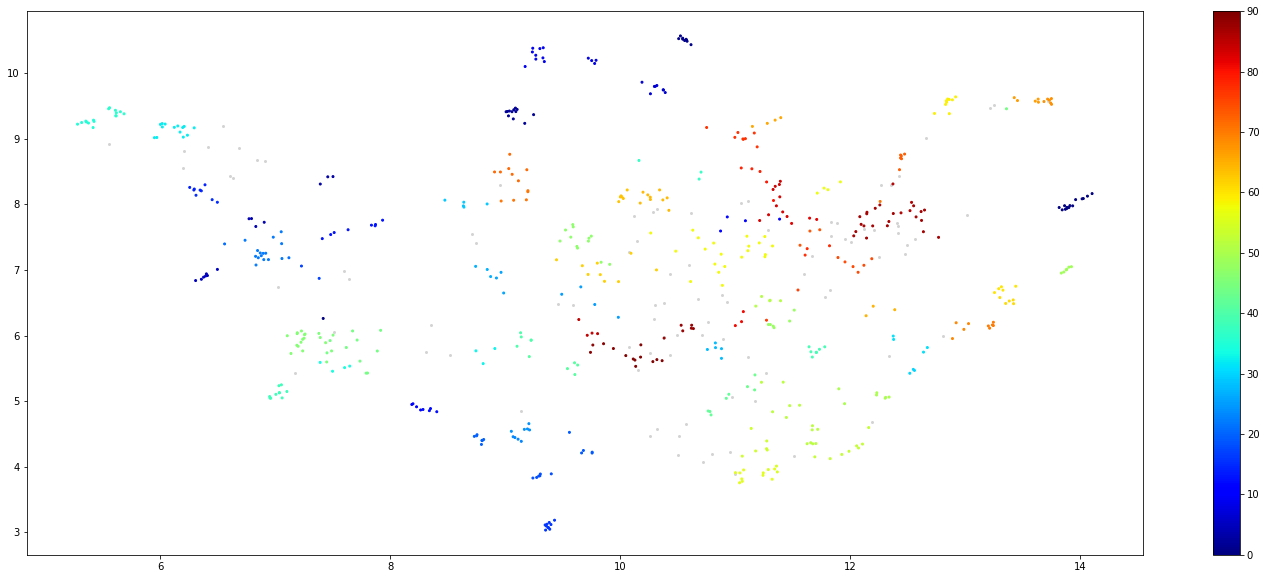

In [ ]:
plot_best_clusters(questions_sbert, cluster_labels, figsize=(25, 10))

In [ ]:
import pandas as pd

In [ ]:
question_assignments = pd.DataFrame({"question": new_questions, "cluster": cluster_labels})
question_assignments.sort_values("cluster", inplace=True, ascending=False)
question_assignments

,question,cluster
504,What is the name of the fictional character ca...,90
199,What is the name given to a fictional turtle?,90
46,What is the pseudonym of the fictional character?,90
419,What is the fictional character's nickname?,90
50,What is the fictional character's given name?,90
...,...,...
162,Whose facial hair is covered by a chin curtain?,-1
174,What type of work is present in cartoons?,-1
178,What type of character wears a necktie?,-1
471,What is the pseudonym of a faked work?,-1


## Option 2: Paraphrase detection with pre-trained models

In [ ]:
import torch

In [ ]:
qpp_data = pd.read_csv("qqp.tsv", sep="\t")

In [ ]:
qpp_data

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [ ]:
all_questions = list(set(list(qpp_data.question1) + list(qpp_data.question2)))
print(f"There are {len(all_questions)} unique questions in QPP data")

There are 537361 unique questions in QPP data


In [ ]:
x, y = qpp_data[["question1", "question2"]].values, qpp_data["is_duplicate"].values

In [ ]:
#Start the multi-process pool on all available CUDA devices
pool = model.start_multi_process_pool()

#Compute the embeddings using the multi-process pool
x_a = model.encode_multi_process(x[:, 0], pool)
x_b = model.encode_multi_process(x[:, 1], pool)

#Optional: Stop the proccesses in the pool
model.stop_multi_process_pool(pool)

In [ ]:
x_a_sample = torch.tensor(x_a[:20]).to(torch.float32)
x_b_sample = torch.tensor(x_b[:20]).to(torch.float32)

x_a_t = torch.tensor(x_a).to(torch.float32)
x_b_t = torch.tensor(x_b).to(torch.float32)

In [ ]:
# Analysing distribution of cosine similarities for positive-negative questions
cosim = torch.nn.CosineSimilarity(dim=1, eps=1e-08)

x_ab_cosim = cosim(x_a_t, x_b_t)

cosim_positive = torch.index_select(
    x_ab_cosim, 0, torch.from_numpy(np.argwhere(y)).flatten()).numpy()
cosim_negative = torch.index_select(
    x_ab_cosim, 0, torch.from_numpy(np.argwhere(1-y)).flatten()).numpy()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


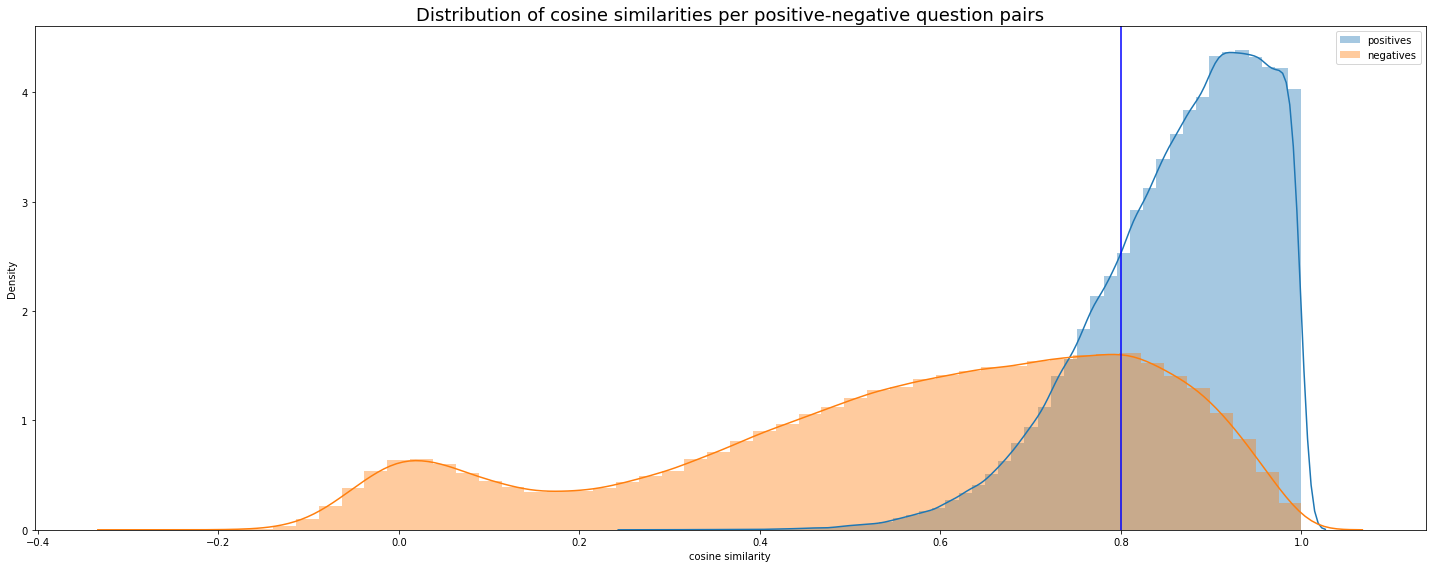

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 8))

sns.distplot(x=cosim_positive, label="positives", ax=ax)
sns.distplot(x=cosim_negative, label="negatives", ax=ax)

ax.legend()
ax.set_title("Distribution of cosine similarities per positive-negative question pairs", fontsize=18)
ax.set_xlabel("cosine similarity")

plt.axvline(x = 0.8, color = 'b')


plt.tight_layout()

## Classification

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

BATCH_SIZE = 128

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [ ]:
X = torch.stack((x_a_t, x_b_t))
X = torch.swapaxes(X, 0, 1)
print(f"X shape: {X.shape}")

# Creating full torch dataset and train-test splits
cqq_dataset = TensorDataset(X, torch.tensor(y).to(torch.float32))

dev_size = int(0.8 * len(cqq_dataset))
test_size = len(cqq_dataset) - dev_size
dev_set, test_set = torch.utils.data.random_split(
    cqq_dataset, [dev_size, test_size])

train_size = int(0.8 * len(dev_set))
valid_size = len(dev_set) - train_size
train_set, valid_set = torch.utils.data.random_split(
    dev_set, [train_size, valid_size])

# Creating data loaders
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=BATCH_SIZE)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

assert len(train_set) + len(valid_set) + len(test_set) == len(cqq_dataset)

X shape: torch.Size([404290, 2, 384])


In [ ]:
class SiameseClassifier(nn.Module):
    def __init__(self, embed_dim, projection=True):
        super().__init__()

        if projection:  # include linear projection layer
          self.projection = nn.Linear(embed_dim, embed_dim)
        # Fully connected layers + binary classification
        self.fc1 = nn.Linear(embed_dim, embed_dim)
        self.batchnorm1 = nn.BatchNorm1d(embed_dim)
        self.fc2 = nn.Linear(embed_dim, 128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 32)
        self.batchnorm3 = nn.BatchNorm1d(32)
        self.classifier = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x_a, x_b):
        # x_a, x_b = x[0], x[1]  # unpacking question embeddings (embed_dim)
        x_a = self.projection(x_a)  # linear projection of x_a (embed_dim)
        x_b = self.projection(x_b)  # linear projection of x_b (embed_dim)
        x = x_a * x_b  # additive/multiplicative feature fusion
        x = F.relu(self.batchnorm1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.batchnorm2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.batchnorm3(self.fc3(x)))
        x = self.dropout(x)
        x = self.classifier(x)
        return x.flatten()

In [ ]:
# del questioner

In [ ]:
questioner = SiameseClassifier(embed_dim=X.shape[-1])
questioner = questioner.to(device=device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.SGD(questioner.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(questioner.parameters(), lr=0.001)
# optimizer = optim.RMSprop(questioner.parameters(), lr=0.001)


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, log=False):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    epoch_loss = 0.

    model.train()  # use dropout and batchnorm

    for batch, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        x_a, x_b = inputs[:, 0, :], inputs[:, 1, :]
        outputs = model(x_a, x_b)

        loss = loss_fn(outputs, labels)
        loss_float = loss.item()
        epoch_loss += loss_float

        loss.backward()
        optimizer.step()

        if batch % 100 == 0 and log:
            current = batch * len(inputs)
            print(f"loss: {loss_float:>7f}  [{current:>5d}/{size:>5d}]")

    epoch_loss /= num_batches
    return epoch_loss


def test_loop(dataloader, model, loss_fn):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    model.eval()  # skip dropout and batchnorm

    with torch.no_grad():
        for inputs, labels in dataloader:
          inputs = inputs.to(device=device)
          labels = labels.to(device=device)
          x_a, x_b = inputs[:, 0, :], inputs[:, 1, :]

          pred = model(x_a, x_b)
          classes = ((torch.sigmoid(pred) > 0.5)+0).ravel()
          classes = classes.to(torch.float32)

          test_loss += loss_fn(pred, labels).item()
          correct += (classes == labels).type(torch.float32).sum().item()

    test_loss /= num_batches
    correct /= size

    return test_loss, correct



In [ ]:
EPOCHS = 1000
PATIENCE = 15

tloss_hist, vloss_hist = [], []
vloss_best, vloss_wait = 100, 0

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    tloss = train_loop(train_loader, questioner, criterion, optimizer)
    print(f"  Training: Avg loss: {tloss:>8f}")
    vloss, vcorrect = test_loop(valid_loader, questioner, criterion)
    print(f"  Validation: acc. {(100*vcorrect):>0.1f}%, Avg loss: {vloss:>8f}")

    if vloss < vloss_best:
      vloss_best = vloss # update the best loss
      vloss_wait = 0  # reset the wait
    else:  # not improving the validation loss
      vloss_wait += 1

    tloss_hist.append(tloss)
    vloss_hist.append(vloss)

    if vloss_wait == PATIENCE:
      print(f"Early stopping at epoch {t}")
      break  # exit the for-loop


tloss, tcorrect = test_loop(test_loader, questioner, criterion)
print(f"\nTest: accuracy {(100*vcorrect):>0.1f}%, Avg loss: {vloss:>8f}")

Epoch 1
-------------------------------
  Training: Avg loss: 0.512259
  Validation: acc. 77.5%, Avg loss: 0.459834
Epoch 2
-------------------------------
  Training: Avg loss: 0.471050
  Validation: acc. 78.8%, Avg loss: 0.439627
Epoch 3
-------------------------------
  Training: Avg loss: 0.454477
  Validation: acc. 79.5%, Avg loss: 0.425127
Epoch 4
-------------------------------
  Training: Avg loss: 0.441080
  Validation: acc. 80.1%, Avg loss: 0.419303
Epoch 5
-------------------------------
  Training: Avg loss: 0.431162
  Validation: acc. 80.2%, Avg loss: 0.411973
Epoch 6
-------------------------------
  Training: Avg loss: 0.423939
  Validation: acc. 80.7%, Avg loss: 0.408244
Epoch 7
-------------------------------
  Training: Avg loss: 0.414212
  Validation: acc. 80.8%, Avg loss: 0.401740
Epoch 8
-------------------------------
  Training: Avg loss: 0.408725
  Validation: acc. 80.9%, Avg loss: 0.399667
Epoch 9
-------------------------------
  Training: Avg loss: 0.402125
 

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


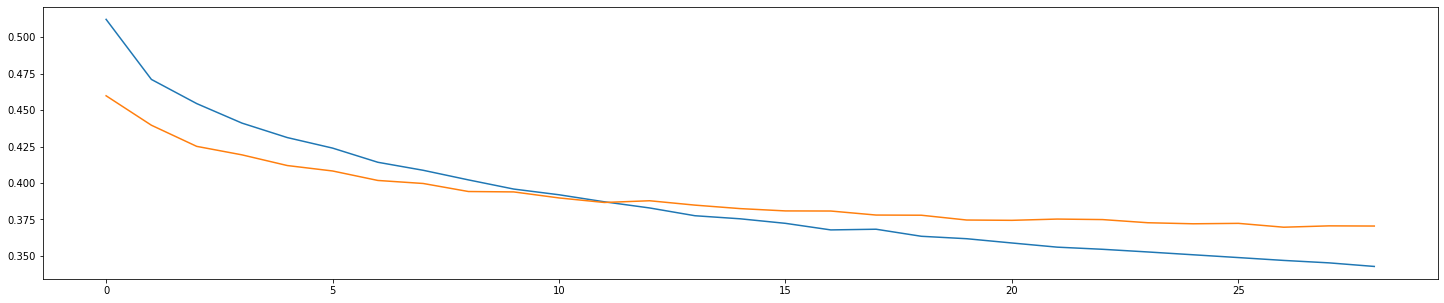

In [ ]:
fig, axes = plt.subplots(figsize=(25, 5))

sns.lineplot(list(range(len(tloss_hist))), tloss_hist, ax=axes)
sns.lineplot(list(range(len(vloss_hist))), vloss_hist, ax=axes)